# run under oephys env

## Modules and Functions

In [ ]:
import sys
import os
# Add the directory to the system path
sys.path.append('C:/Users/BingShiuan/OneDrive - Harvard University/桌面/rotatoin labs/farrell/ErniePlaceCells')
# Now you can import the module/file and use its functions
import BayesianDecoder as bayes
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.ndimage import gaussian_filter1d as gauss
from open_ephys.analysis import Session

from scipy.stats import zscore
import pandas as pd
import shutil
import subprocess
from pathlib import Path

def Encoder2pos(chA, chB, th):
    chA = (chA > th) * 1
    chB = (chB > th) * 1
    chA_plus_minus = (chA * 2) - 1
    chB_diff = np.concatenate(([0], np.diff(chB)))
    chA_prod = chA_plus_minus * chB_diff
    chB_plus_minus = (chB * 2) - 1
    chA_diff = np.concatenate(([0], np.diff(chA)))
    chB_prod = -chB_plus_minus * chA_diff
    position = np.cumsum(chA_prod + chB_prod)
    return (position/4) * (44.8/256) #circumfence in cm divided number of pulses per revolution


def zscore_activity(trace, NN=False, percentile=20):
    """
    Z-score calcium or deconvolved spikes.
    
    Parameters
    ----------
    trace : np.ndarray
        1D (time,) or 2D (n_cells, time) array.
    NN : bool
        If False: z-score calcium using `percentile` as baseline.
        If True : standard z-score, then clip negatives to 0 (for deconvolved spikes).
    percentile : float
        Percentile used as baseline when NN is False (default: 20).
    
    Returns
    -------
    z : np.ndarray
        Z-scored (and optionally non-negative) trace, same shape as `trace`.
    """
    x = np.asarray(trace)

    if x.ndim not in (1, 2):
        raise ValueError("trace must be 1D or 2D array")

    if NN:
        # Standard z-score per trace/cell, then non-negative
        if x.ndim == 1:
            mu = np.mean(x)
            sigma = np.std(x)
            if sigma == 0:
                sigma = 1.0
            z = (x - mu) / sigma
            z = np.clip(z, 0, None)
        else:  # 2D: (n_cells, time)
            mu = np.mean(x, axis=1, keepdims=True)
            sigma = np.std(x, axis=1, keepdims=True)
            sigma[sigma == 0] = 1.0
            z = (x - mu) / sigma
            z = np.clip(z, 0, None)

    else:
        # Percentile-based baseline (for calcium)
        if x.ndim == 1:
            baseline = np.percentile(x, percentile)
            baseline_mask = x <= baseline
            sigma = np.std(x[baseline_mask])
            if sigma == 0:
                sigma = 1.0
            z = (x - baseline) / sigma
        else:  # 2D: (n_cells, time)
            baseline = np.percentile(x, percentile, axis=1, keepdims=True)
            baseline_mask = x <= baseline
            # std over baseline values per cell (avoid mixing with non-baseline)
            # use nan masking for convenience
            baseline_vals = np.where(baseline_mask, x, np.nan)
            sigma = np.nanstd(baseline_vals, axis=1, ddof=0)
            sigma[sigma == 0] = 1.0
            sigma = sigma[:, None]
            z = (x - baseline) / sigma

    return z
def normalize_dim(data, axis):
    """
    Normalizes a numpy array along a specified dimension (axis) to the [0, 1] range.

    Args:
        data (np.ndarray): The input array.
        axis (int): The dimension along which to normalize.

    Returns:
        np.ndarray: The normalized array.
    """
    # Calculate min and max along the specified axis, keeping dimensions for broadcasting
    min_vals = np.min(data, axis=axis, keepdims=True)
    max_vals = np.max(data, axis=axis, keepdims=True)
    
    # Apply the min-max normalization formula
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data

import imageio_ffmpeg

def crop_with_ffmpeg(input_path, output_path, x, y, w, h, q=5):
    """
    Crop ROI and convert to grayscale, then save as AVI with MJPEG (fast).
    - x,y,w,h: ROI in pixels (top-left + width/height)
    - q: MJPEG quality (1=best/largest, 31=worst/smallest). 3–8 is common.
    """
    ffmpeg = imageio_ffmpeg.get_ffmpeg_exe()

    # MJPEG is happier with even dimensions too; also avoids some edge-case issues.
    x -= x % 2
    y -= y % 2
    w -= w % 2
    h -= h % 2
    w = max(w, 2)
    h = max(h, 2)

    vf = f"crop={w}:{h}:{x}:{y},format=gray"

    cmd = [
        ffmpeg, "-y",
        "-i", str(input_path),
        "-vf", vf,
        "-c:v", "mjpeg",
        "-q:v", str(q),
        "-an",                 # no audio (often simplest for analysis videos)
        str(output_path),
    ]

    print("Running:\n ", " ".join(cmd))
    p = subprocess.run(cmd, text=True, capture_output=True)
    if p.returncode != 0:
        print("\n--- ffmpeg stderr ---\n", p.stderr)
        raise RuntimeError(f"ffmpeg failed with code {p.returncode}")

    print("Saved:", output_path)
from pathlib import Path

def list_all_folders_pathlib(directory_path):
    """Lists all immediate subfolders in a given directory."""
    path = Path(directory_path)
    # Use iterdir() to get all items and is_dir() to filter for directories
    folders = [item.name for item in path.iterdir() if item.is_dir()]
    return folders

# linear to circular position
def lin2circ(hall, hall_th, pos):
    hall_binary = np.where(hall < hall_th, 1, 0)
    hall_def = hall_binary[1:] - hall_binary[:-1]
    loop_start = np.where(hall_def== 1)[0]
    if len(loop_start)==0:
        pos_offset1 = pos
        loop_len=[]
    else:

        pos_offset = pos - pos[loop_start[0]]
        previous_off = loop_start[0]
        loop_len=[]

        pos_offset1 = pos_offset.copy()
        pos_offset2 = pos_offset.copy()
        for idx in np.concatenate((loop_start,[0])): #from second offset
            if idx != loop_start[0]:
                pos_offset1_copy = pos_offset1.copy()
                pos_offset1[previous_off:] -= pos_offset1_copy[previous_off]
                loop_len.append(pos_offset1_copy[previous_off])
                previous_off=idx
        # rescue the missed hall sensing (not yet finished)
            #get mean loop length
        loop_len = np.asarray(loop_len, dtype=float) 
        loop_miss = np.where(loop_len-np.median(loop_len) > 100)[0] #only consider twice length (miss once)
        loop_len_adjust = loop_len.copy()
        loop_len_adjust[loop_miss] = loop_len[loop_miss]/2
        loop_len_mean = np.mean(loop_len_adjust[1:])
        #find the skipped points
    # offset_inferred=[]
    # for m in loop_miss:
    #     missed_period = pos_offset1[loop_start[m]:loop_start[m+1]]
    #     min_index = np.argmin(missed_period-loop_len_mean)
    #     offset_inferred.append(min_index+loop_start[m])


        pos_offset1[:loop_start[0]] += loop_len_mean
        print(loop_len)
    plt.plot(pos_offset1, color='k', linewidth=2)
    # plt.plot(pos_offset2[0:500000], color='r', linewidth=2)
    # plt.scatter(loop_start[0],0)
    # plt.scatter(offset_inferred,np.zeros(len(offset_inferred))+loop_len_mean)
    # plt.xlim(0, 500000)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    return pos_offset1, loop_len

# sync to 2P
def sync2P(F_all,twoP_TTL,oephys_data):
    cal_frames = F_all.shape[1]

    twoP_TTL_binary = np.where(twoP_TTL>20000, 1, 0)

    TTL_def = twoP_TTL_binary[:-1] - twoP_TTL_binary[1:]
    TTL_time = np.where(TTL_def == -1)[0] #high threshold, missing TTL when it takes two frames to complete an edge. Currently recoverved by adding pulse. Should find other smarter ways.
    TTL_interval = TTL_time[1:] - TTL_time[:-1] 

    print(cal_frames)
    print(TTL_time.shape[0])
    print(TTL_interval.max(),TTL_interval.min(),np.median(TTL_interval))
    if (TTL_interval.max() - TTL_interval.min()) >1:
        print("missing TTL")
    ds_oephys_data = oephys_data[:,TTL_time]
    if cal_frames > ds_oephys_data.shape[1]:
        print("OpenEphys truncated")
        F_all_trunc = F_all[:,0:ds_oephys_data.shape[1]]
    elif  cal_frames < ds_oephys_data.shape[1]:
        print("Calcium truncated")
        F_all_trunc = F_all
        ds_oephys_data = ds_oephys_data[:,0:cal_frames]
    else: 
        print("perfectly matched!!")
        F_all_trunc = F_all

    print(F_all_trunc.shape[1])
    print(ds_oephys_data.shape[1])

    return F_all_trunc, ds_oephys_data

In [139]:
#[temp] slice calcium
import pandas as pd

path = r"G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0122 stim slice/rec3.csv"   # or "/Users/you/file.xlsx"
df = pd.read_csv(path)         # reads the first sheet by default
arr = df.to_numpy() 
F_all = arr[:,1:].T
print(F_all)
print(F_all.shape)                # (rows, columns)


[[261.73  280.24  290.795 ... 213.78  217.364 225.523]
 [407.495 442.437 441.088 ... 385.775 362.19  377.047]
 [268.949 293.706 270.478 ... 267.184 265.412 249.812]
 ...
 [376.264 346.807 341.322 ... 336.784 328.49  355.879]
 [273.545 287.776 307.16  ... 284.845 278.712 291.931]
 [115.702 113.667 110.719 ... 102.681 102.389 103.38 ]]
(7, 2000)


In [3]:
print(ops)

{'suite2p_version': '0.14.4', 'look_one_level_down': 0.0, 'fast_disk': 'G:/Shared drives/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/suite2p', 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'nwb_file': '', 'nwb_driver': '', 'nwb_series': '', 'save_path0': 'G:/Shared drives/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/suite2p', 'save_folder': 'suite2p', 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 0.33, 'fs': 30.0, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': 0.0, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': 0.0, 'combined': 1.0, 'aspect': np.float64(1.0), 'do_bidiphase': False, 'bidiphase': 0.0, 'bidi_corrected': False, 'do_registration': 1, 'two_step_registration': 0.0, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 500, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': True, 'reg_ti

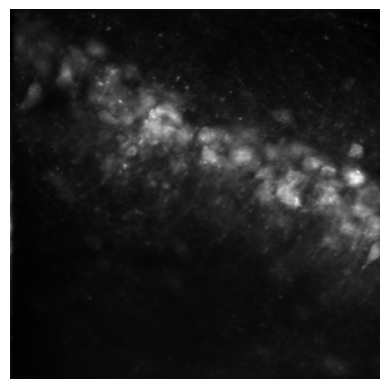

(177, 12000)
[ 3000  6000  9000 12000]


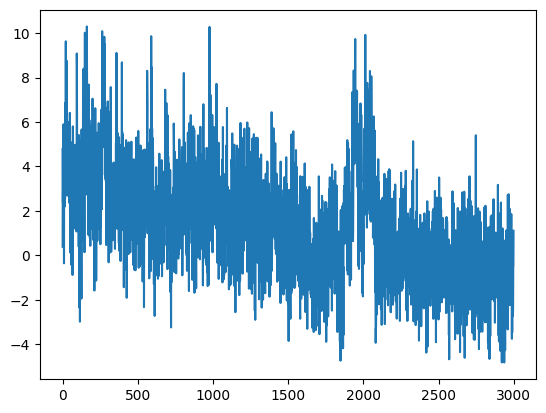

In [15]:
#Calcium data (suite2p)
# dates = ["20260112","20260114"]
# trial = [2,1]
dates = ["20250129","20250129","20250129","20250129"]
trial = [1,1,1,1]
exper = [0,1,2,3]

# foldername = r'C:/Users/BingShiuan/OneDrive - Harvard University/桌面/rotatoin labs/farrell/2P/DK047/251215/session 1/Calcium/suite2p/plane0'  # <-- change to your folder
# foldername = r'G:/共用雲端硬碟/Lab Resources/Data/Dennis/2P/DK47/0112_0114 suite2p/suite2p/plane0'
foldername = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/suite2p/suite2p/plane0'
F_concat_all = np.load(foldername+'/F.npy')
Fneu_concat_all = np.load(foldername+'/Fneu.npy')
spks_concat = np.load(foldername+'/spks.npy')

F_use = F_concat_all-(0.7*Fneu_concat_all)

iscell = np.load(foldername+'/iscell.npy')
ops = np.load(foldername+'/ops.npy', allow_pickle=True).item()
meanImg = ops['meanImg'] 
plt.imshow(meanImg, cmap='gray')
plt.axis('off')
plt.show()
print(F_concat_all.shape)
#chunk
frame_each = ops['frames_per_file']
frame_cum = np.cumsum(frame_each)
print(frame_cum)
F_zs_each = {}
prev_frame = 0
if len(dates)==len(frame_cum):
    for i in range(len(dates)):
        F_each = F_use[np.where(iscell[:,0] == 1),prev_frame:frame_cum[i]]
        F_zs_each[i] = zscore_activity(F_each[0],NN=False,percentile=30)
        prev_frame = frame_cum[i]
else:
    print("data not match")
plt.plot(F_zs_each[1][20,:])

In [12]:
print(exp)

9


Open Ephys GUI Recording
ID: 0x225b0fe88d0
Format: Binary
Directory: G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/0129 stim BW03/1/2026-01-29_17-01-50\Record Node 103\experiment1\recording9
Experiment Index: 0
Recording Index: 0


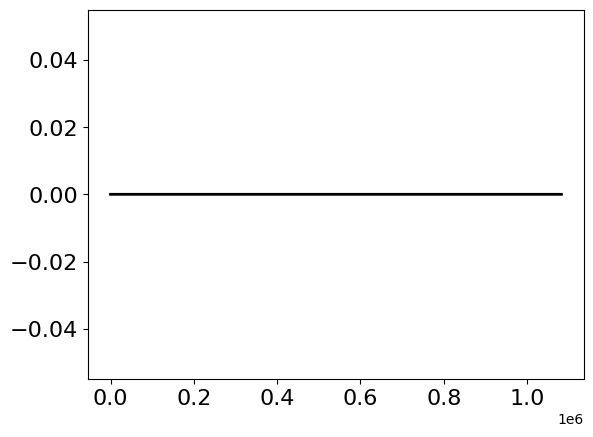

3000
3000
331 330 331.0
perfectly matched!!
3000
3000
Open Ephys GUI Recording
ID: 0x225b12c7c10
Format: Binary
Directory: G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/0129 stim BW03/1/2026-01-29_17-01-50\Record Node 103\experiment1\recording10
Experiment Index: 0
Recording Index: 1


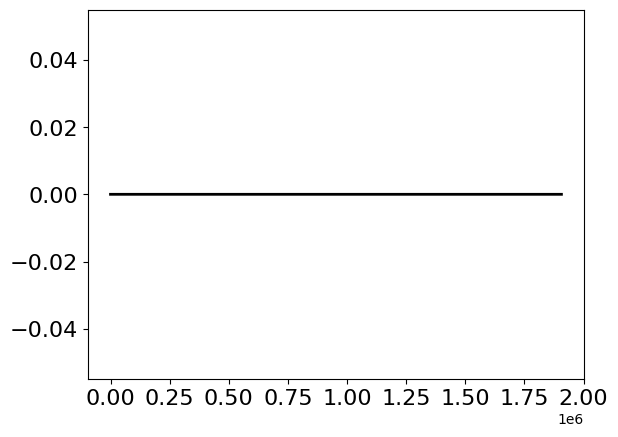

3000
3807
169081 330 331.0
missing TTL
Calcium truncated
3000
3000
Open Ephys GUI Recording
ID: 0x225b7d18b90
Format: Binary
Directory: G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/0129 stim BW03/1/2026-01-29_17-01-50\Record Node 103\experiment1\recording11
Experiment Index: 0
Recording Index: 2


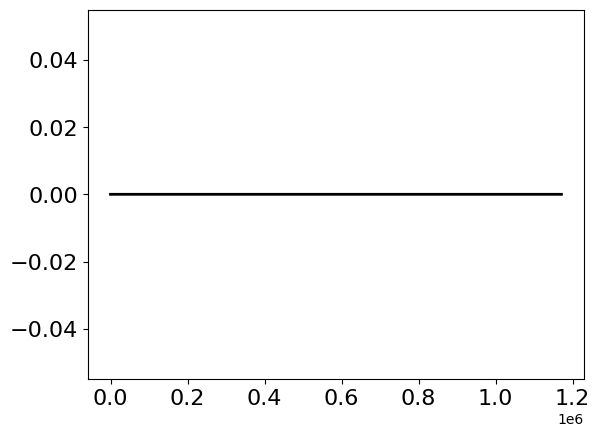

3000
3000
331 330 331.0
perfectly matched!!
3000
3000
Open Ephys GUI Recording
ID: 0x225b0b1afd0
Format: Binary
Directory: G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/0129 stim BW03/1/2026-01-29_17-01-50\Record Node 103\experiment1\recording12
Experiment Index: 0
Recording Index: 3


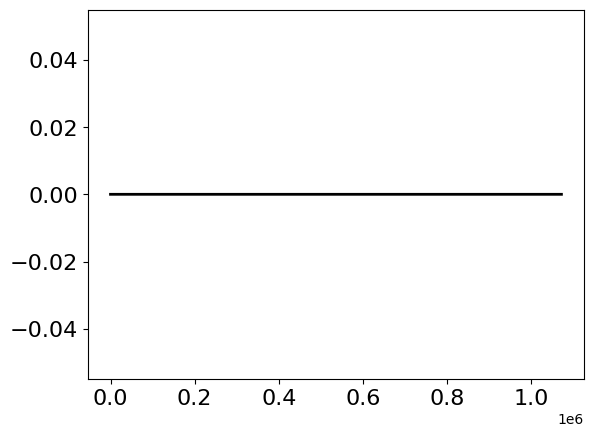

3000
3000
331 330 331.0
perfectly matched!!
3000
3000


In [38]:
#Behavior data (openephys)
F_all_trunc, ds_oephys_data={},{}
for d in range(len(dates)):

    # data_dir = r'C:/Users/BingShiuan/OneDrive - Harvard University/桌面/rotatoin labs/farrell/2P/DK047/251215/session 1/Openephys/2025-12-15_17-49-34'  # <-- change to your folder
    # data_dir = r'G:/共用雲端硬碟/Lab Resources/Data/Dennis/2P/DK47/'+dates[d]+'/'+str(trial[d])+'/'  # <-- change to your folder
    # data_dir = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0122 stim slice/2026-01-22_18-15-24'
    data_dir = r'G:/共用雲端硬碟/Lab Resources/Data/BingShiuan rotation/0129 stim BW03/0129 stim BW03/'+str(trial[d])+'/'  # <-- change to your folder
    subfolder = list_all_folders_pathlib(data_dir)
    data_path = data_dir+subfolder[0]
    session = Session(data_path)   # detects Binary/OpenEphys/NWB automatically

    # If you only have one Record Node:
    exp = exper[d]
    recordings = session.recordnodes[0].recordings

    rec0 = recordings[exp]          # first recording #which experiment?
    cont0 = rec0.continuous[0]    # first continuous stream

    data = cont0.samples          # numpy array, shape (n_samples, n_channels)
    fs = cont0.metadata.sample_rate
    t = np.arange(data.shape[0]) / fs   # time vector in seconds


    chB = data[:, 1]  #need to check A and B
    chA = data[:, 2]
    hall = data[:, 3]
    camera_pulse = data[:,4]
    led = data[:,5] #ch6
    stim = data[:,7] #ch8
    twoP_TTL = data[:, 0] 
    pos = Encoder2pos(chA, chB, 1000)
    speed = gauss(np.concatenate( (np.array([0]), pos[1:] - pos[:-1])) * fs, 500)
    speed = np.abs(speed)
    time=np.arange(0,len(speed))/(fs)
    hall_th = 15000
    print(recordings[exp])

    # processing
    [pos_offset, loop_len]=lin2circ(hall,hall_th,pos)
    # oephys_data = np.vstack((pos_offset, speed))
    oephys_data = np.vstack((pos_offset, speed,stim))
    F_all_trunc[d], ds_oephys_data[d] = sync2P(F_zs_each[d],twoP_TTL,oephys_data)


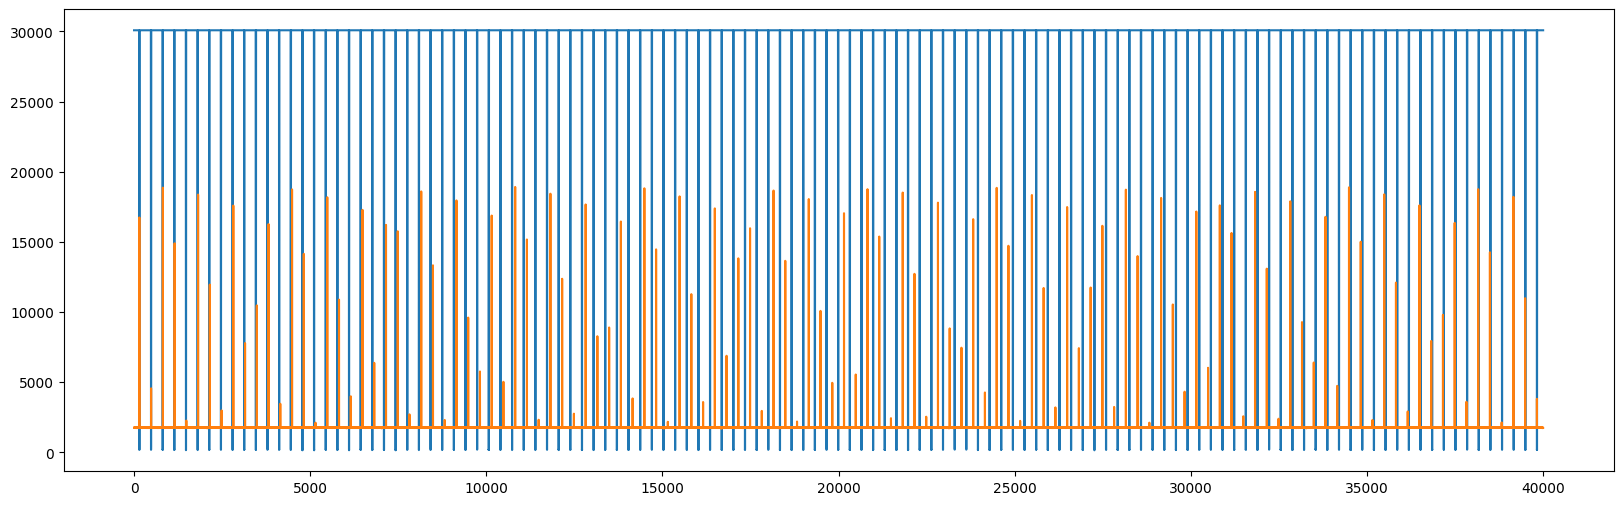

In [26]:
window = range(10010000,10050000)
plt.figure(figsize=(20, 6))
plt.plot(twoP_TTL[window])
plt.plot(camera_pulse[window])
# plt.plot(TTL_sync[window])

2 667 333.0
7387436


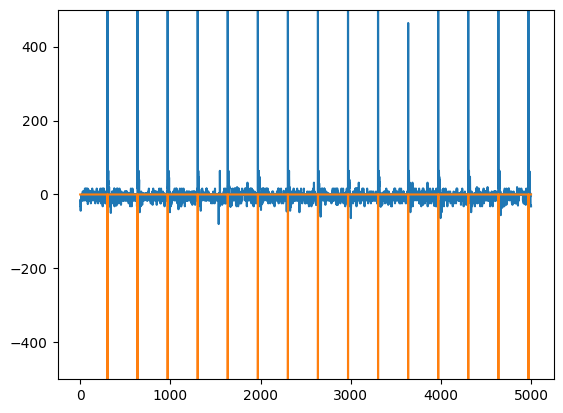

In [217]:

w = 30

med = pd.Series(camera_pulse).rolling(window=w, center=False).median().to_numpy()
# med = np.median(camera_pulse)
camera_pulse_offset = camera_pulse - med

cam_pulse_binary = (camera_pulse_offset>250)*1
cam_pulse_def = cam_pulse_binary[1:] - cam_pulse_binary[:-1]
cam_pulse_time = np.where(cam_pulse_def== 1)[0]
cam_pulse_interval = cam_pulse_time[1:] - cam_pulse_time[:-1] 
show = range(12890000,12895000)
plt.plot(camera_pulse_offset[show])
plt.plot(cam_pulse_binary[show]*-1000)
plt.ylim([-500,500])
print(min(cam_pulse_interval),max(cam_pulse_interval),np.median(cam_pulse_interval))
print(cam_pulse_time[np.argmin(cam_pulse_interval)])

In [36]:
print(F_all_trunc)

{0: array([[ 0.8912272 ,  5.279511  ,  3.680217  , ...,  1.7193205 ,
         0.6269416 , -2.70725   ],
       [ 0.80017954,  2.0150585 ,  0.34993535, ..., -0.02568053,
         0.43999258, -3.9054766 ],
       [-1.6721308 , -0.28788352,  0.50643504, ..., -1.4869429 ,
        -0.2232679 ,  1.1423895 ],
       ...,
       [ 1.8735135 ,  5.8489904 ,  4.7788925 , ...,  1.9842024 ,
        -1.103466  ,  1.1485174 ],
       [ 2.191125  ,  5.874259  ,  5.411486  , ...,  0.74033904,
        -0.9956051 , -4.1375413 ],
       [ 4.3504205 ,  6.0242863 ,  5.3158674 , ...,  0.24809508,
        -1.5211037 , -0.68765575]], shape=(31, 3000), dtype=float32), 1: array([[ 0.8912272 ,  5.279511  ,  3.680217  , ...,  1.7193205 ,
         0.6269416 , -2.70725   ],
       [ 0.80017954,  2.0150585 ,  0.34993535, ..., -0.02568053,
         0.43999258, -3.9054766 ],
       [-1.6721308 , -0.28788352,  0.50643504, ..., -1.4869429 ,
        -0.2232679 ,  1.1423895 ],
       ...,
       [ 1.8735135 ,  5.8489904 , 

In [68]:
print(iscell_origin)

(array([  2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  20,  22,  23,  24,  25,  27,  32,  34,  36,  37,
        42,  63,  66, 107, 175]),)


(array([16]),)
[1]
(array([12]),)
[ 0  2  4  8 11]
(array([2]),)
[0 2 4 8]
(array([5]),)
[2]


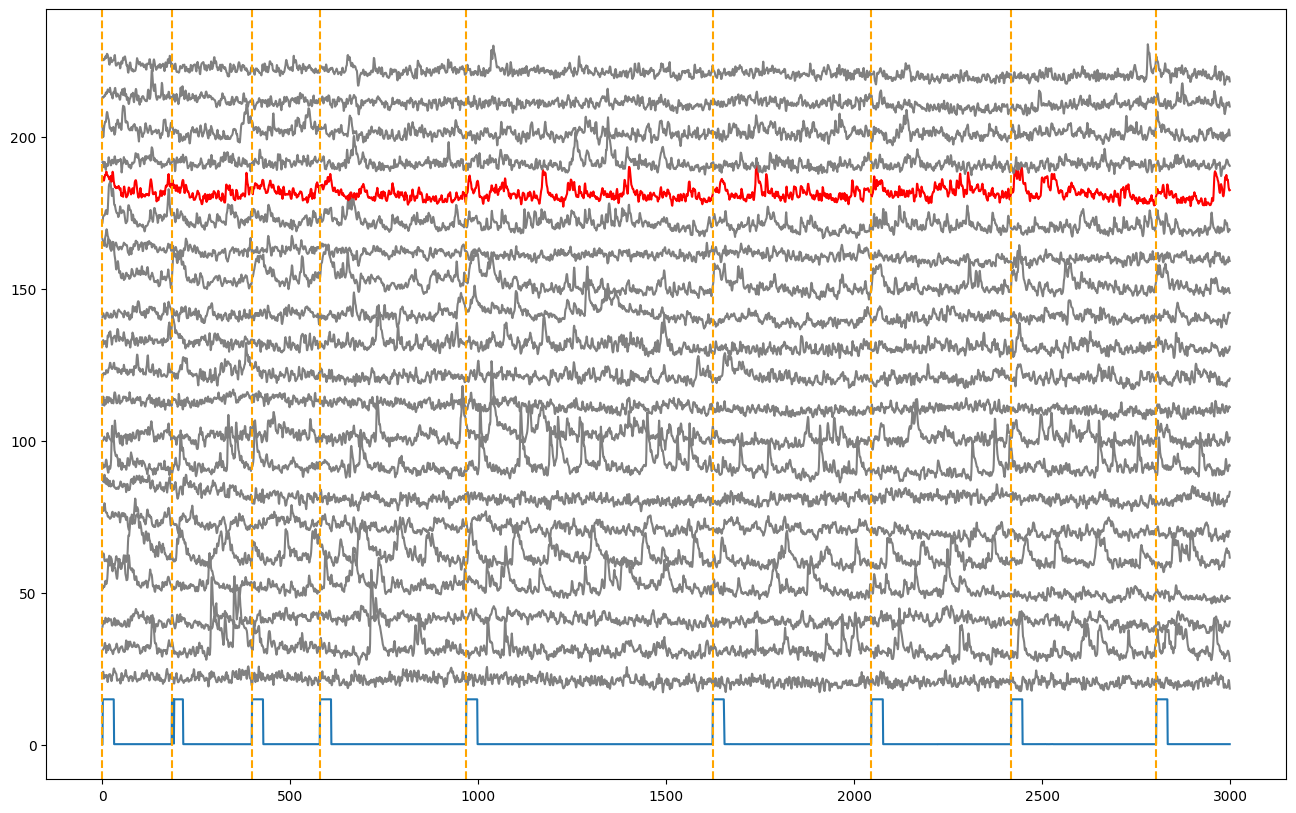

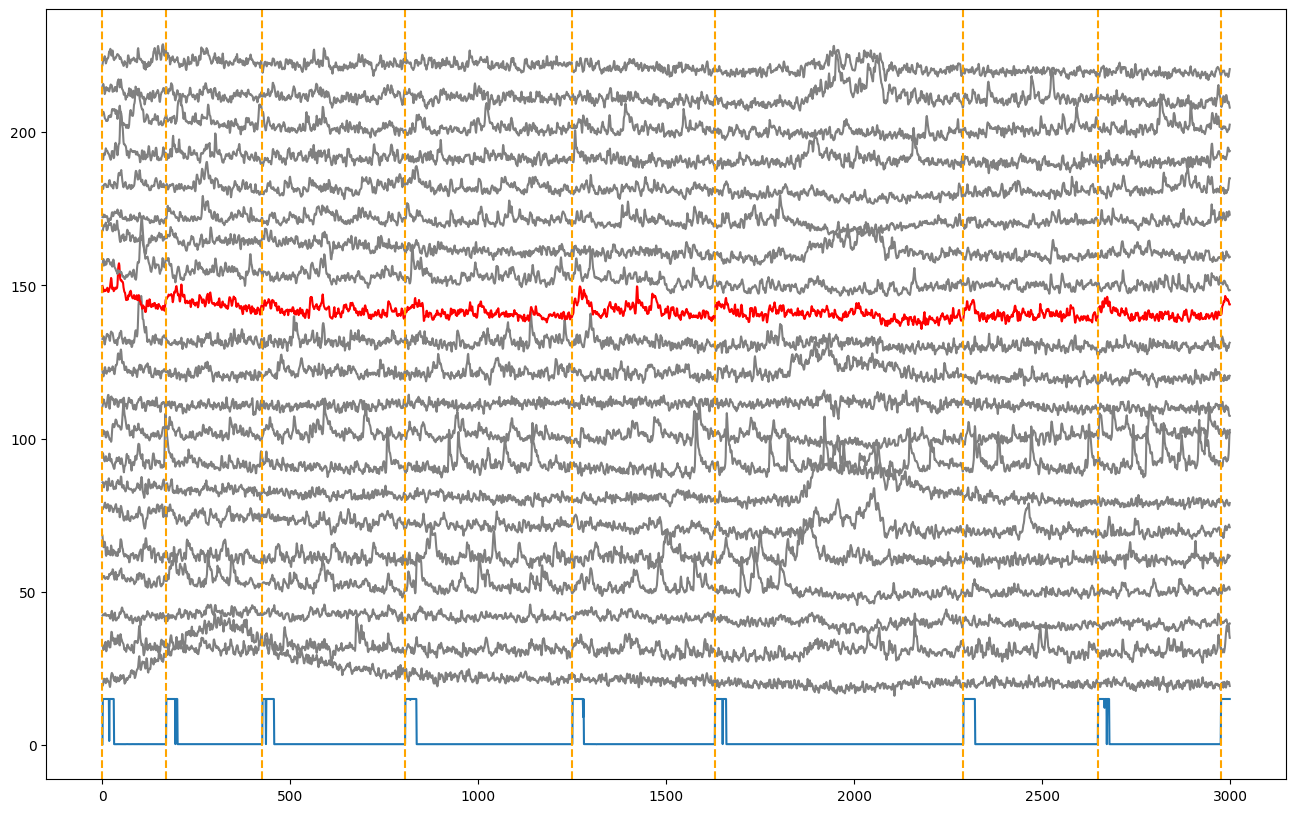

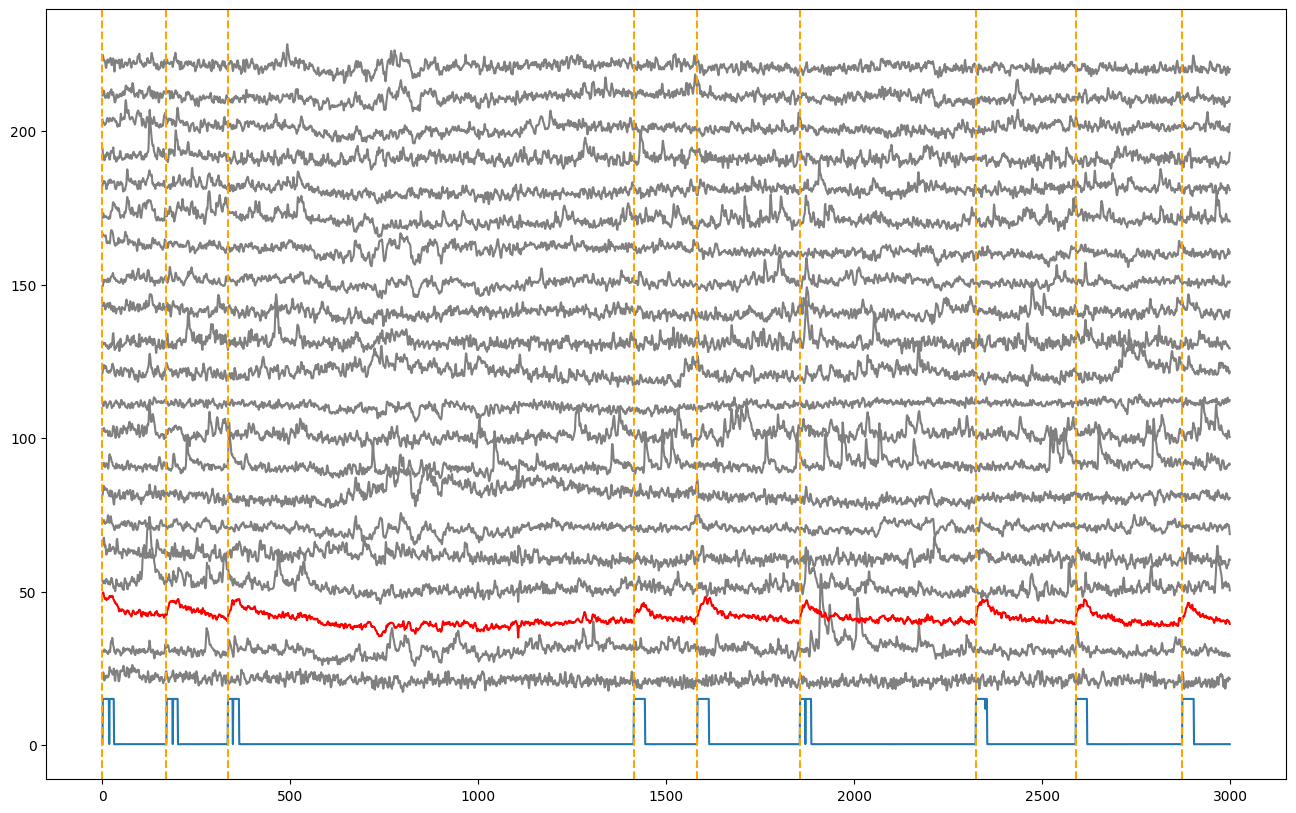

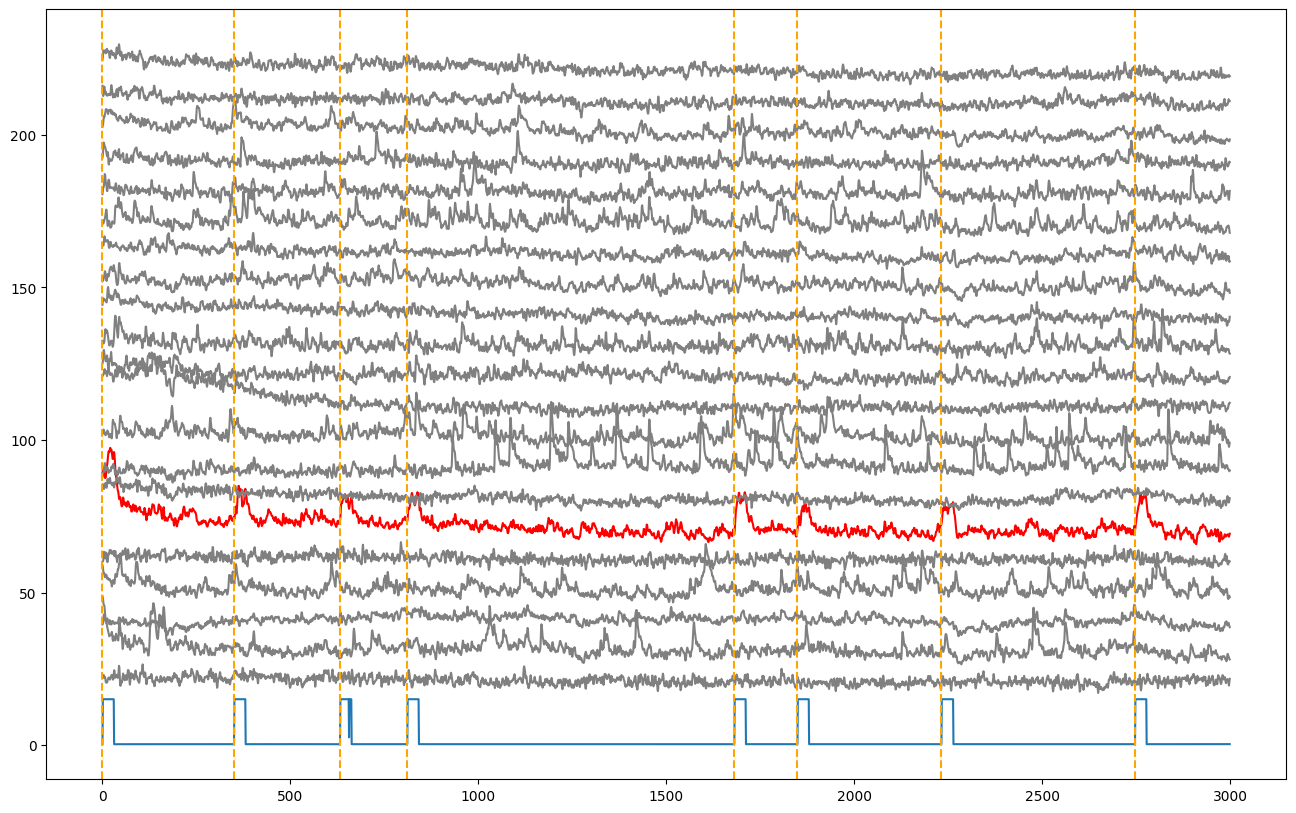

In [81]:

from scipy.ndimage import gaussian_filter1d
ROI = [20,15,5,8]
for t in range(4):
    # F_all_zs = zscore_activity(F_all_trunc[t],NN=False,percentile=50)
    F_sm_zs = gaussian_filter1d(F_all_trunc[t], axis=1, sigma=1)
    
    plt.figure(figsize=(16,10))
    # plt.plot(ds_led/2000)
    ds_stim = ds_oephys_data[t][2,:]
    plt.plot(ds_stim/2000)

    iscell_origin = np.where(iscell[:,0] == 1)[0]
    # print(ROI[t])
    target = np.where(iscell_origin == ROI[t])
    print(target)
    ds_stim_bin = (ds_stim>10000)*1
    stim_bin_def = ds_stim_bin[1:] - ds_stim_bin[:-1]
    stim_time = np.where(stim_bin_def== 1)[0]
    stim_time_def = stim_time[1:] - stim_time[:-1] #to find false dipping because of down sampling
    short_interval = np.where(stim_time_def<33)[0]
    print(short_interval)
    stim_time = np.delete(stim_time, short_interval+1)
    offset = 10  # vertical spacing (change this)
    for i in range(F_sm_zs.shape[0]-10):
        if i==target[0]:
            c = "r"
        else:
            c = "gray"
        plt.plot(F_sm_zs[i,:] + (i+2) * offset, color=c)
        

    for x0 in stim_time:
        plt.axvline(x=x0, linestyle="--", color="orange")
    plt.show


In [ ]:
#resample camera
from scipy.signal import resample_poly
import cv2

video_path = data_dir+'/FaceVid.avi'
out_path   = data_dir+'/cropped.avi'

cap = cv2.VideoCapture(video_path)
ok, frame0 = cap.read()
cap.release()
if not ok:
    raise RuntimeError("Could not read first frame")

# Pop up ROI GUI: drag rectangle with mouse
# Press ENTER or SPACE to accept, ESC to cancel
x, y, w, h = map(int, cv2.selectROI("Draw ROI (drag). Enter=OK, Esc=Cancel", frame0,
                                    fromCenter=False, showCrosshair=True))
cv2.destroyAllWindows()

if w == 0 or h == 0:
    raise RuntimeError("ROI cancelled/invalid")

print("ROI:", x, y, w, h)



crop_with_ffmpeg(video_path,out_path,x, y, w, h)



ROI: 208 81 78 54
Running:
  c:\Users\BingShiuan\anaconda3\envs\oephys\Lib\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe -y -i G:/共用雲端硬碟/Lab Resources/Data/Dennis/2P/DK47/20251229/1/2025-12-29_20-07-07/FaceVid.avi -vf crop=78:54:208:80,format=gray -c:v mjpeg -q:v 5 -an G:/共用雲端硬碟/Lab Resources/Data/Dennis/2P/DK47/20251229/1/2025-12-29_20-07-07/cropped.avi


In [ ]:



# x: 1D array (or use axis=... for multi-D)
# Fs1 -> Fs2
P, Q = 160, 147   # example: 44.1 kHz -> 48 kHz ratio = 48000/44100 = 160/147
y = resample_poly(x, up=P, down=Q)

(12171325,)
30000


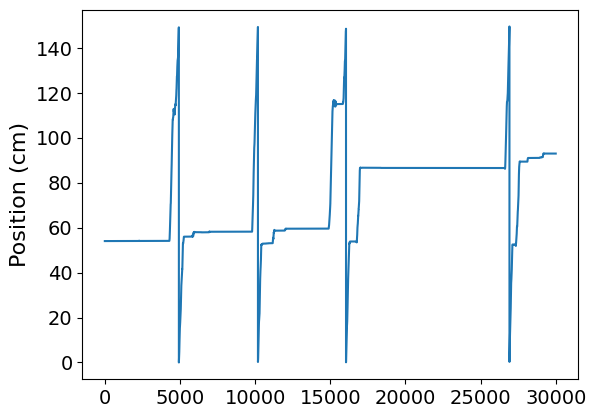

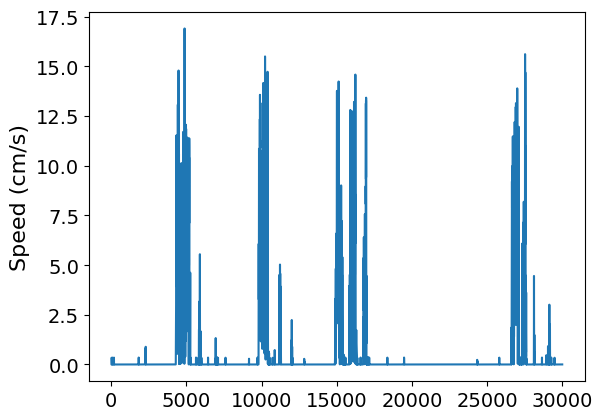

In [19]:
print(speed.shape)
print(ds_pos.shape[0])
plt.plot(ds_pos)
plt.ylabel("Position (cm)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

plt.plot(ds_speed)
plt.ylabel("Speed (cm/s)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim([215000,210000])
plt.show()

In [86]:
print(ds_oephys_data[0].shape)

(2, 30000)


In [27]:
from scipy.ndimage import gaussian_filter1d
from scipy import stats
t=1

ds_speed = ds_oephys_data[t][1,:]
ds_pos = ds_oephys_data[t][0,:]

mask = ds_speed > 3
position = ds_pos[mask]
ca_all = F_all_trunc[t][:, mask]


mean_pos_tune=[]
se_pos_tune=[]
std_pos_tune=[]
for cellID in range(ca_all.shape[0]):
    ca  = ca_all[cellID, :]   # same length as pos, 1D
    pos_range = None
    nbins = 28 #~5 cm per bin Noah et al.,2022; Jordan et al.,2024
    # Range of positions to bin over
    if pos_range is None:
        pos_min, pos_max = position.min(), position.max()
    else:
        pos_min, pos_max = pos_range

    # Bin edges and centers
    edges = np.linspace(pos_min, pos_max, nbins + 1)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    # Which bin each sample falls into (0..nbins-1)
    idx = np.digitize(position, edges) - 1
    # Clip anything on the right edge into last bin
    idx = np.clip(idx, 0, nbins - 1)

    # Sum calcium and count samples per bin
    sum_ca = np.bincount(idx, weights=ca, minlength=nbins)
    counts = np.bincount(idx, minlength=nbins)
    sum_ca2  = np.bincount(idx, weights=ca**2, minlength=nbins)
    # Mean calcium per bin
    with np.errstate(divide="ignore", invalid="ignore"):
        mean_ca = sum_ca / counts
        var_ca  = (sum_ca2 - counts * mean_ca**2) / (counts - 1)
        std_ca  = np.sqrt(var_ca)
        se_ca = std_ca/(counts**0.5)

    mean_ca[counts == 0] = np.nan  # bins with no samples
    mean_pos_tune.append(mean_ca) 
    std_pos_tune.append(std_ca)
    se_pos_tune.append(se_ca)
mean_pos_tune_array = np.vstack(mean_pos_tune)
std_pos_tune_array = np.vstack(std_pos_tune)
se_pos_tune_array = np.vstack(se_pos_tune)

mean_diff = 1
mean_pos_tune_array_extent = mean_pos_tune_array.max(axis=1) - np.median(mean_pos_tune_array, axis=1)
mean_pos_tune_array_PC = np.where(mean_pos_tune_array_extent>mean_diff)[0]
mean_pos_tune_array_nPC = np.where(mean_pos_tune_array_extent<=mean_diff)[0]
tune_idx = mean_pos_tune_array[mean_pos_tune_array_PC,:].argmax(axis=1)
tune_idx_sort = np.argsort(tune_idx,)[::-1]



In [23]:
print(mean_pos_tune_array_PC)

[4]


(1,)


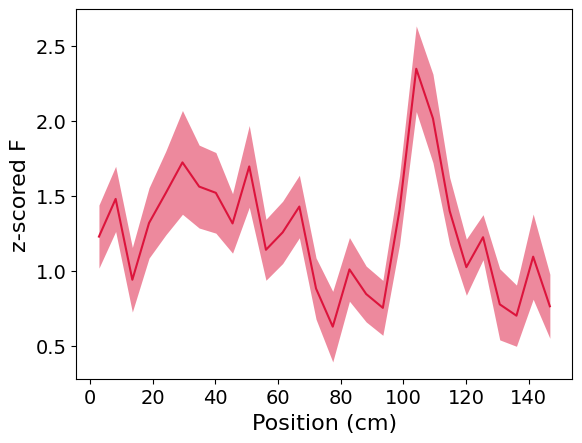

In [29]:

cellID = 4
print(tune_idx_sort.shape)
# plt.scatter(pos,ca_all[cellID, :] , edgecolors='none', color='k',s=10,alpha=0.3) # only under calcium, 1kHz spike train is noisy and mostly 1/0
# plt.show()
y = mean_pos_tune_array[cellID,:]
err = se_pos_tune_array[cellID,:]
plt.plot(bin_centers, y,'crimson')
plt.fill_between(bin_centers, y-err, y+err, color='crimson', alpha=0.5,linewidth=0)
plt.xlabel("Position (cm)",fontsize=16)
plt.ylabel("z-scored F",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# plt.figure(figsize=(10, 5)) 
# plt.plot(gaussian_filter1d(F_all_trunc[cellID, :],sigma=5),color='k',lw=0.5)
# plt.ylabel("z-scored F",fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlim([10000,15000])

In [54]:


# ca_zs = stats.zscore(ca_all, axis=1)

ca_PC = ca_all[mean_pos_tune_array_PC,:] # running only
ca_nPC = ca_all[mean_pos_tune_array_nPC,:]
pos_show = position


C:\Users\BingShiuan\AppData\Local\Temp\ipykernel_40452\2805678558.py:20: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  h = ax[1].imshow(ca_nPC, vmin=vmin, vmax=vmax,cmap='hot',aspect=10)


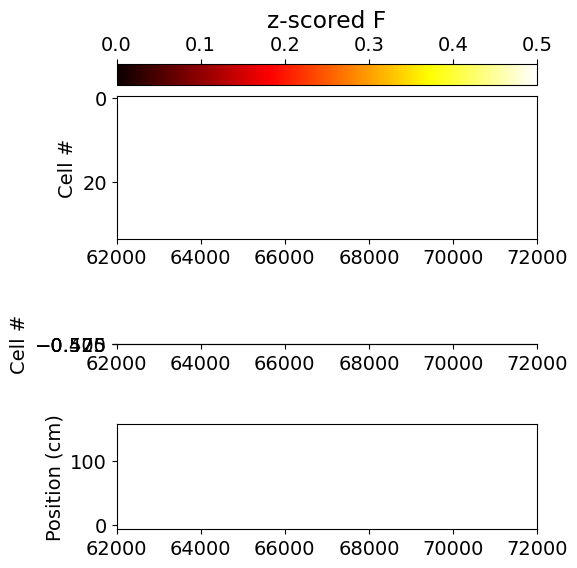

In [55]:

# ca_PC = F_all_trunc[mean_pos_tune_array_PC,:] #all
# ca_nPC = F_all_trunc[mean_pos_tune_array_nPC,:]
# pos_show = ds_pos

F_all_trunc_sort = ca_PC[tune_idx_sort,:]

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(3, 1, figsize=(6, 6),gridspec_kw={'height_ratios': [2,2, 1]})
showrange = [62000,72000]
vmin = 0
vmax = 0.5
h = ax[0].imshow(F_all_trunc_sort, vmin=vmin, vmax=vmax,cmap='hot',aspect=100)
ax[0].set_ylabel('Cell #')
clb = fig.colorbar(h, orientation='horizontal',location='top')
clb.ax.set_title('z-scored F')
ax[0].set_xlim(showrange)



h = ax[1].imshow(ca_nPC, vmin=vmin, vmax=vmax,cmap='hot',aspect=10)
ax[1].set_ylabel('Cell #')
ax[1].set_xlim(showrange)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


ax[2].plot(pos_show)
ax[2].set_xlim(showrange)#(0, F_all_trunc_sort.shape[1])
ax[2].set_ylabel('Position (cm)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [550]:
#bayesian decoding
spatial_bin = 1
step = 1
bin_scale_factor = pos_max/nbins
spkraster = ca_PC
posFR_all = mean_pos_tune_array[mean_pos_tune_array_PC,:]
print(spkraster.shape)
p_x_n = bayes.BayesianDecoder(spkraster,posFR_all,spatial_bin,step,20,include_end=False)

(24, 72516)


In [197]:
print(pos_min)

0.0


(3625,)


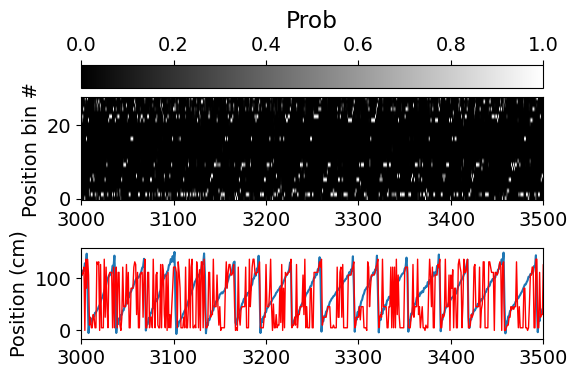

(28, 3625)


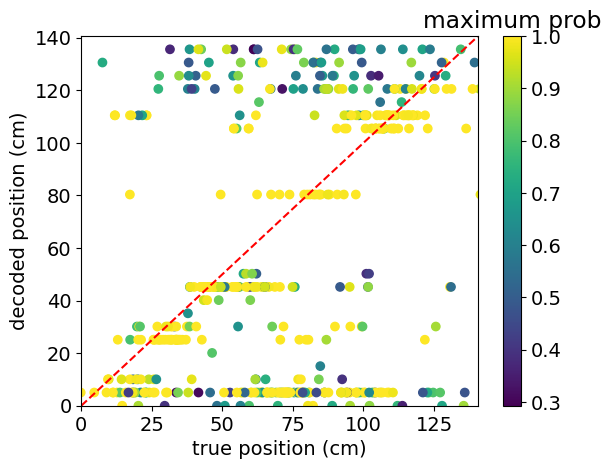

In [555]:
pos_bin = scipy.signal.resample(position,p_x_n.shape[1])
print(pos_bin.shape)

fig, ax = plt.subplots(2, 1, figsize=(6, 4),gridspec_kw={'height_ratios': [2, 1]})
showrange = [3000,3500]

h = ax[0].imshow(p_x_n, vmin=0, vmax=1,cmap='gray',aspect=4,origin='lower')
ax[0].set_ylabel('Position bin #')
clb = fig.colorbar(h, orientation='horizontal',location='top')
clb.ax.set_title('Prob')
ax[0].set_xlim(showrange)
# plt.colorbar()
# plt.show()
ax[1].plot(pos_bin)
ax[1].set_xlim(showrange)
ax[1].set_ylabel('Position (cm)')
ax[1].plot(np.argmax(p_x_n, axis=0)*bin_scale_factor,"r", linewidth=1)
plt.tight_layout()
plt.show()
plt.scatter(pos_bin[showrange[0]:showrange[1]],np.argmax(p_x_n[:,showrange[0]:showrange[1]], axis=0)*bin_scale_factor,c=np.max(p_x_n[:,showrange[0]:showrange[1]], axis=0))
plt.xlabel("true position (cm)")
plt.ylabel("decoded position (cm)")
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.xlim([0,pos_max])
plt.ylim([0,pos_max])
clb2 = plt.colorbar()
clb2.ax.set_title('maximum prob')
print(p_x_n.shape)
